In [86]:
import glob
import os
import sys
from itertools import cycle
from pathlib import Path, PureWindowsPath

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tifffile
import skimage
import pandas as pd
from skimage.filters import threshold_li
from tqdm.notebook import tqdm, trange
from skimage import exposure, io
from joblib import Parallel, delayed
import napari
import anndata as ad
import scanorama
import scanpy as sc
from fbpca import pca
from geosketch import gs
from matplotlib.pyplot import rc_context
import h5py
sc.settings.verbosity = 3

In [ ]:
path = Path.cwd().parent / 'data' / 'meta' / 'pixels.h5ad'
adata = ad.read_h5ad(path)
adata.var_names = adata.var_names.str.upper()

In [88]:
X = adata.obsm['X_scanorama']

# Geosketch

In [4]:
neigh=20
N = int(X.shape[0] / neigh)

In [ ]:
sketch_index = gs(X, N,  seed=0, replace=False)

In [ ]:
len(sketch_index)

In [ ]:
# write clustering to disk
np.save(
    Path.cwd().parent / 'data' / 'clustering'/ 'index.npy', sketch_index
)

# Subsample pixel clustering

In [8]:
# Check that the subset is the same 
sketch_index= np.load(
    Path.cwd().parent / 'data' / 'clustering'/ 'index.npy'
)


In [9]:
adata_subset = adata[sketch_index,:]

In [10]:
adata_subset

View of AnnData object with n_obs × n_vars = 189356 × 15
    obs: 'Cell Type', 'Cell', 'FOV', 'X', 'Y', 'cluster'
    uns: 'cluster_colors'
    obsm: 'X_scanorama'

In [7]:
sc.pp.neighbors(adata_subset, metric='cosine', use_rep='X_scanorama')
sc.tl.umap(adata_subset)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:28)


In [8]:
sc.tl.leiden(adata_subset)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:07:14)


In [9]:

# with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
#     fig = sc.pl.umap(adata_subset, color=["FOV"], size=5)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


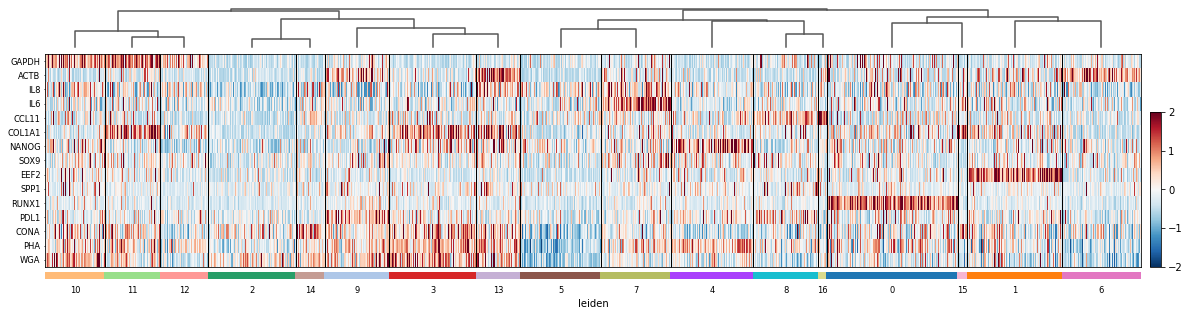

In [10]:
sc.pl.heatmap(
    adata_subset,
    adata_subset.var_names.tolist(),
    "leiden",
    dendrogram=True,
    cmap="RdBu_r",
    swap_axes=True, 
    figsize=(20,5),
    vmin=-2, 
    vmax=2,
)

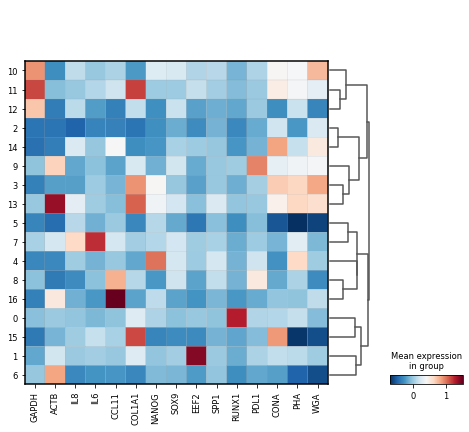

In [20]:
sc.pl.matrixplot(
    adata_subset,
    adata_subset.var_names.tolist(),
    "leiden",
    dendrogram=True,
    cmap="RdBu_r",
    vmax=1.5
)

In [13]:
path = Path.cwd().parent / 'data' / 'clustering' / 'pixels_subset.h5ad'
adata_subset.write(path)

# Propagate to whole dataset

In [11]:
import pynndescent

def get_max_frequency_label(labels, neighs, n):
    df = pd.get_dummies(labels)
    dummies = df.values
    dummies_labels = np.array(df.columns.tolist())
    window = dummies[neighs]
    window = window.reshape(-1, n_neighbor, dummies.shape[1])
    window = window.sum(axis=1) / n_neighbor
    
    assert len(window) == len(neighs)
    return dummies_labels[np.argmax(window, axis=1)]

def missing_elements(X, L):
    start, end = 0, len(X)-1
    return sorted(set(range(start, end + 1)).difference(L))

In [17]:
# Define batch size
batch_size = 200000

# Get NNDescent index for fast projection
X_clustered = adata_subset.obsm['X_scanorama']
index = pynndescent.NNDescent(X_clustered)

# Get subset labels
labels = adata_subset.obs.cluster

In [18]:
not_sketch_index = missing_elements(X, sketch_index)

In [19]:
# Get non sketch samples
X_no_label = adata.obsm['X_scanorama'][not_sketch_index]
print(len(X), len(X_no_label), len(sketch_index))

3787124 3597768 189356


In [20]:
n_neighbor = 30

# project clusters
clustering = []
samples = X_no_label
for i in np.arange(0, samples.shape[0], batch_size):
    print(f"processing chunk {i}")
    cur_samples = samples[i : i + batch_size]
    neighs = index.query(cur_samples.astype(np.float32), k=n_neighbor)[0]
    clustering.append(
        get_max_frequency_label(labels, neighs, n_neighbor)
    )

processing chunk 0
processing chunk 200000
processing chunk 400000
processing chunk 600000
processing chunk 800000
processing chunk 1000000
processing chunk 1200000
processing chunk 1400000
processing chunk 1600000
processing chunk 1800000
processing chunk 2000000
processing chunk 2200000
processing chunk 2400000
processing chunk 2600000
processing chunk 2800000
processing chunk 3000000
processing chunk 3200000
processing chunk 3400000


In [21]:
full_labels = np.concatenate(clustering)

In [22]:
adata.obs['cluster'] = ''
adata.obs['cluster'][not_sketch_index] = full_labels
adata.obs['cluster'][sketch_index]  = labels

C:\Users\thu71\AppData\Local\Temp\ipykernel_59980\3946896152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cluster'][not_sketch_index] = full_labels
C:\Users\thu71\AppData\Local\Temp\ipykernel_59980\3946896152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cluster'][sketch_index]  = labels


In [24]:
adata.uns['cluster_colors'] = adata_subset.uns['cluster_colors']

In [25]:
path = Path.cwd().parent / 'data' / 'meta' / 'pixels_clusters.h5ad'
adata.write(path)

# Show cluster result

In [26]:
from typing import Optional

def get_img_from_data(x: np.ndarray, y: np.ndarray, data: np.ndarray, pad: int = 0) -> np.ndarray:
    # X is row and Y col
    x_coord = x - x.min() + pad
    y_coord = y - y.min() + pad
    # create image
    img = np.zeros(
        (x_coord.max() + 1 + pad, y_coord.max() + 1 + pad, data.shape[-1]),
        dtype=data.dtype,
    )
    img[x_coord, y_coord] = data
    return img

def hex2rgb(h):
    """Convert hex color string to rgb tuple."""
    h = h.lstrip("#")
    return [int(h[i : i + 2], 16) for i in (0, 2, 4)]

def annotate_img(
    img: np.ndarray,
    annotation: Optional[pd.DataFrame] = None,
    from_col: str = "clustering",
    to_col: Optional[str] = None,
    color: bool = False,
) -> np.ndarray:
    """
    Annotate cluster image.
    Parameters
    ----------
    img
        Image to annotate.
    annotation
        :attr:`Cluster.cluster_annotation` containing mapping of classes to cluster names and colors.
    from_col
        Annotation column containing current values in image.
    to_col
        Annotation column containing desired mapping. If None, use ``from_col``.
    color
        If True, use annotation column ``to_col+"_colors"`` to get colormap and color image.
    Returns
    -------
    Annotated image.
    """
    if to_col is None:
        to_col = from_col
    if color:
        to_col = to_col + "_colors"
        res = np.zeros(img.shape + (3,), dtype=np.uint8)
    else:
        if from_col == to_col:
            # no need to change anything
            return img
        assert annotation is not None
        res = np.zeros_like(img, dtype=annotation[to_col].dtype)
    assert annotation is not None
    for _, row in annotation.iterrows():
        to_value = row[to_col]
        if color:
            to_value = hex2rgb(to_value)
        res[img == row[from_col]] = to_value
    return res.squeeze() if color else res

In [27]:
annotations = pd.DataFrame()
annotations['cluster'] = adata.obs.cluster.cat.categories
annotations['cluster_colors'] = adata.uns['cluster_colors']

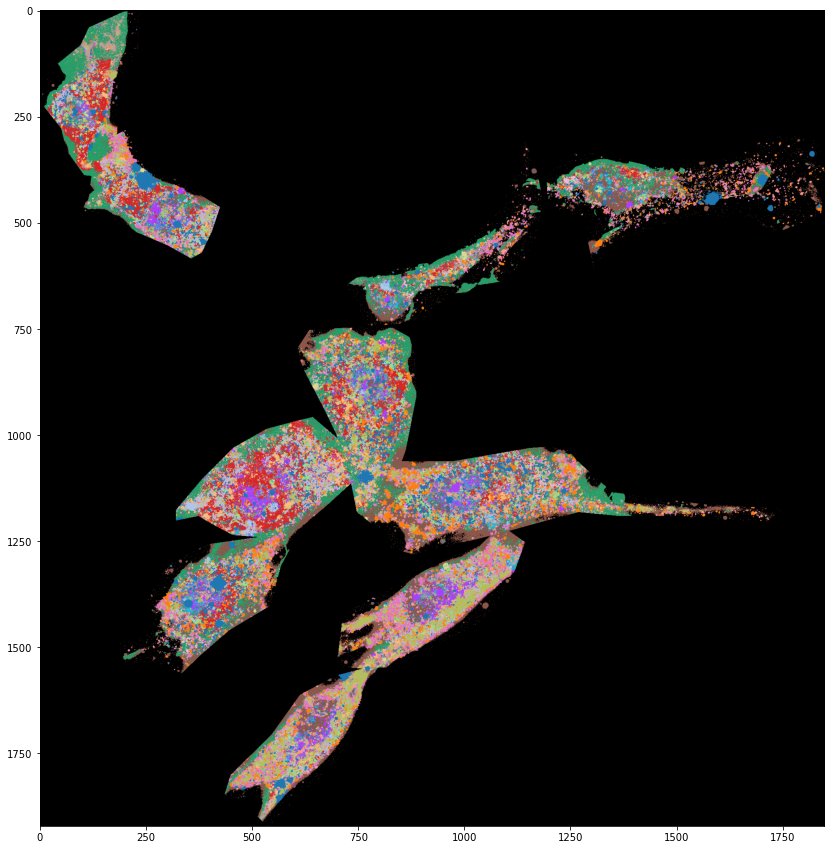

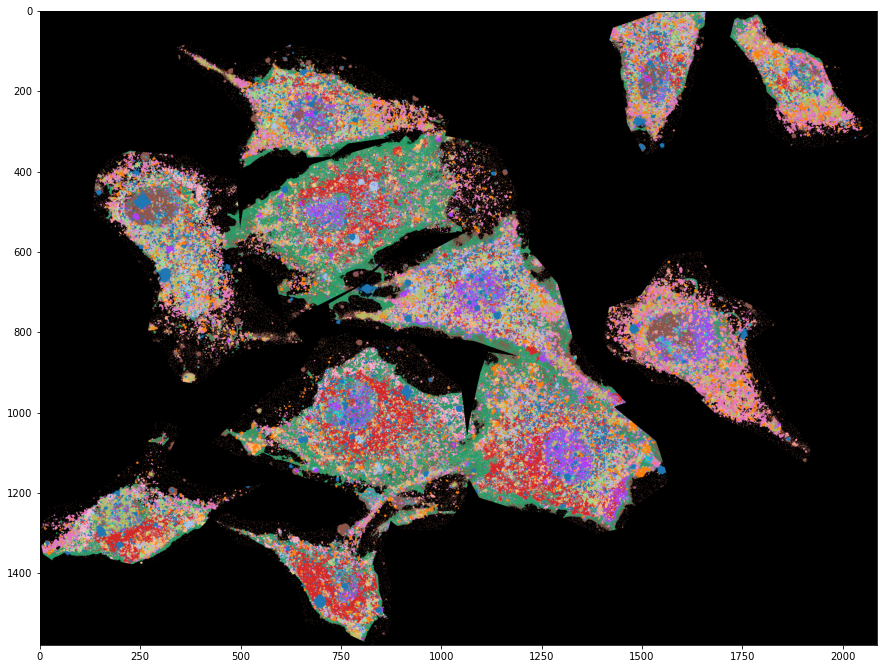

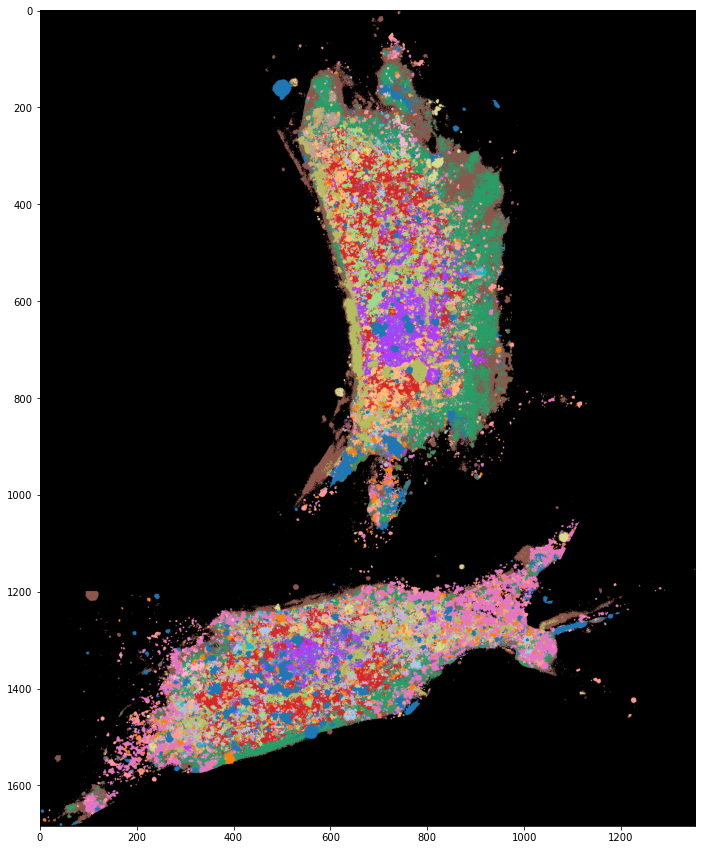

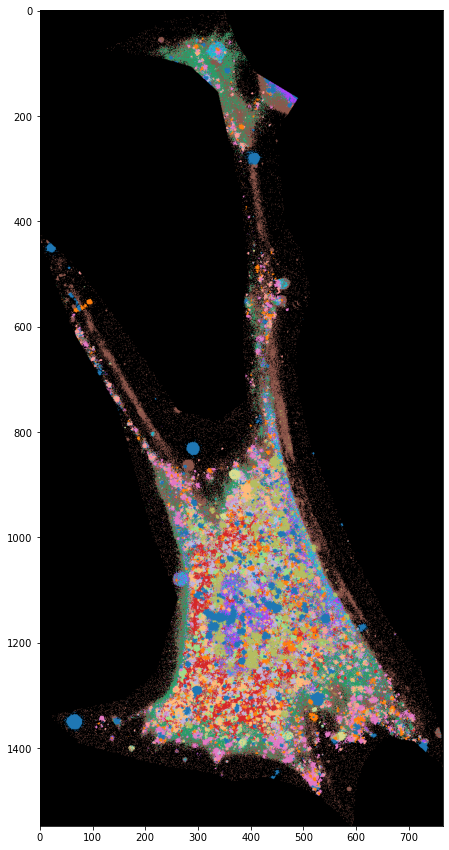

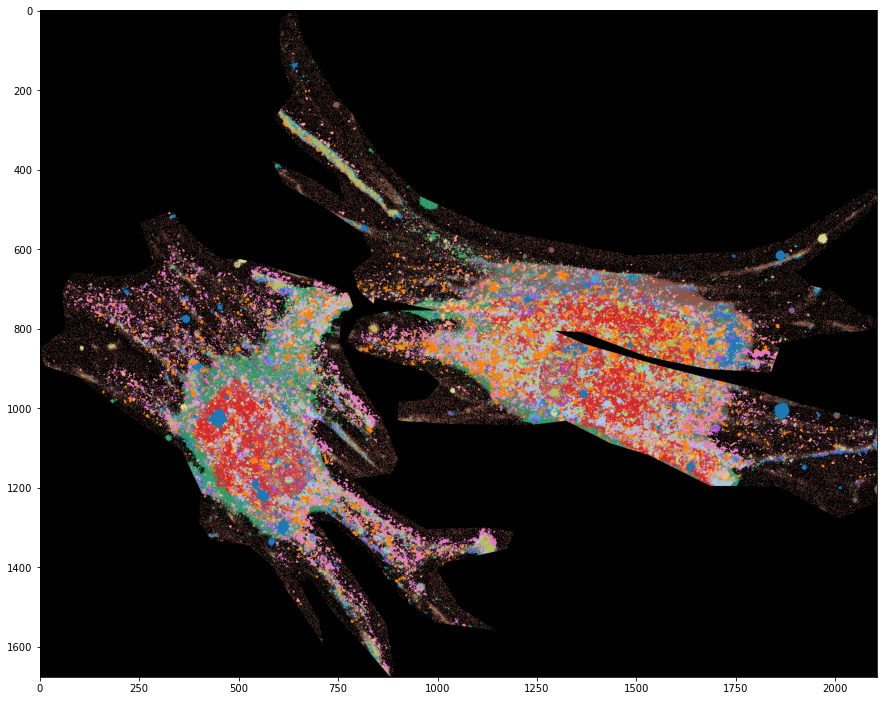

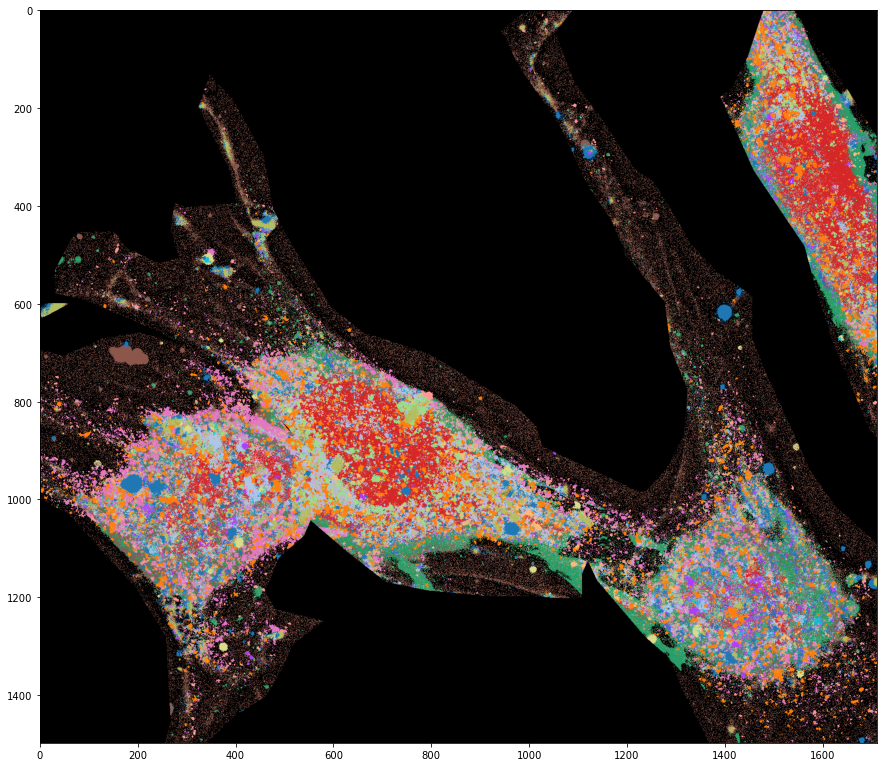

In [28]:
fovs = np.unique(adata.obs.FOV)

for ii, fov in enumerate(fovs):
    adata_fov = adata[adata.obs.FOV == fov]
    
    x = np.array(adata_fov.obs.X.values)
    y = np.array(adata_fov.obs.Y.values)
    values = np.array(adata_fov.obs.cluster.values)
    
    if len(values.shape) == 1:
            values = values[:, np.newaxis]
    img_cluster = get_img_from_data(x, y, values)
    img_cluster_annotated = annotate_img(img_cluster, annotations, from_col='cluster', color=True)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(img_cluster_annotated)
    plt.show()

# Stats plot

In [29]:
path = Path.cwd().parent / 'data' / 'meta' / 'pixels_clusters.h5ad'
adata = ad.read_h5ad(path)

In [46]:
sns.set_context('poster', font_scale=0.7)

# Check that the subset is the same 
sketch_index= np.load(
    Path.cwd().parent / 'data' / 'clustering'/ 'index.npy'
)

adata_subset = adata[sketch_index,:]

sc.pl.heatmap(
    adata_subset,
    adata_subset.var_names.tolist(),
    "cluster",
    dendrogram=True,
    cmap="RdBu_r",
    swap_axes=True, 
    figsize=(20,6),
    vmin=-2, 
    vmax=2,
)

sc.pl.matrixplot(
    adata_subset,
    adata_subset.var_names.tolist(),
    "cluster",
    dendrogram=True,
    cmap="RdBu_r",
    vmax=1.5
)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`


In [47]:
df_obs = adata.obs

In [48]:
df_obs['Cell Type'] = df_obs['Cell Type'].str.upper()

In [49]:
df_obs.loc[df_obs['Cell Type'] == 'UC', 'Cell Type'] = 'HUC'
df_obs.loc[df_obs['Cell Type'] == 'BM', 'Cell Type'] = 'HBM'

In [50]:
df_obs['C'] = df_obs['Cell Type'].astype(str) + '_' + df_obs['Cell'].astype(str)

In [78]:
df_counts = (
df_obs.groupby(['Cell Type', 'cluster'])
.size()
.unstack(fill_value=0)
)

df_counts = df_counts.div(df_counts.sum(axis=1), axis=0)

<AxesSubplot:xlabel='cluster', ylabel='Cell Type'>

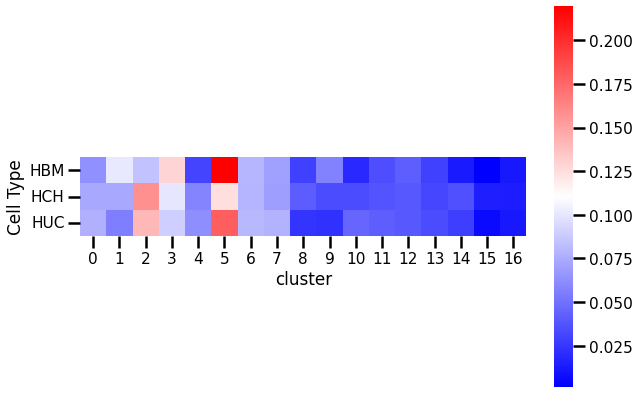

In [79]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_counts+0.001, square=True, cmap='bwr', ax=ax)

In [80]:
import scipy 
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import seaborn as sns

In [81]:
num_cells = len(df_counts)
distMatrix = np.zeros(shape = (num_cells, num_cells))
for ii in range(num_cells):
    for jj in range(num_cells):
        distMatrix[ii,jj] = scipy.stats.wasserstein_distance(df_counts.iloc[ii].to_numpy(), df_counts.iloc[jj].to_numpy())
        
# define distance array as in linked answer
distArray = ssd.squareform(distMatrix) 

# define linkage object
distLinkage = hierarchy.linkage(distArray, )

ValueError: setting an array element with a sequence.

C:\Users\thu71\.conda\envs\thomas-env\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


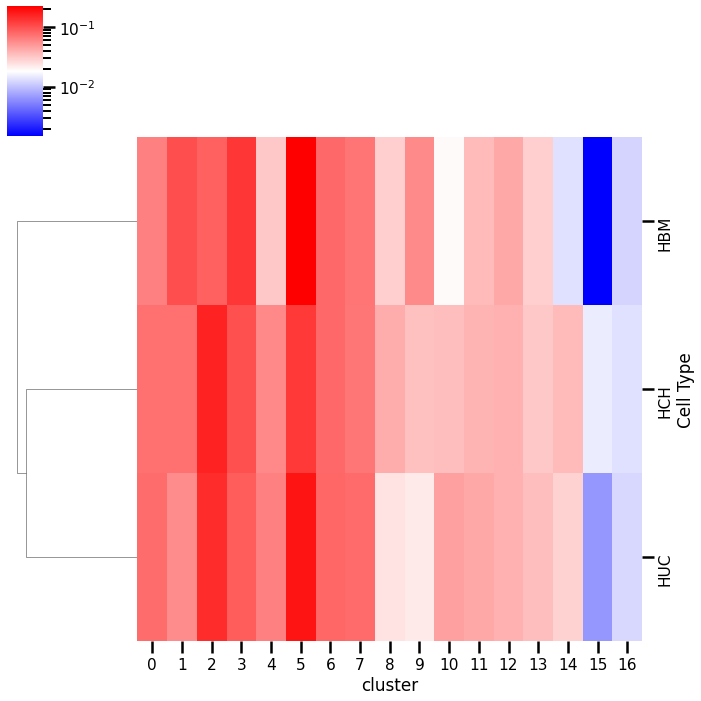

In [82]:
ax = sns.clustermap(df_counts+0.001, square=True, cmap='bwr', row_linkage=distLinkage, norm=LogNorm(), col_cluster=False, figsize=(10,10), yticklabels=True)